In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
# import time
import matplotlib.pyplot as plt
# from PIL import Image
# from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-01-13 09:42:52.370911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736761372.414372   18212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736761372.422135   18212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 09:42:52.462393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = './dataset/'
batch_size = 32
img_height = 256
img_width = 256
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
 
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# df = pd.read_table('./dataset/captcha_data.csv', sep=',', dtype={'solution': str})

Found 5631 files belonging to 4 classes.
Using 4505 files for training.


I0000 00:00:1736761378.294770   18212 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [3]:
# Checking that the different classes

class_names = train_ds.class_names
print(class_names)

['cloudy', 'desert', 'green_area', 'water']


In [22]:
# Checking that the classes are balanced

from collections import Counter

# Initialize a Counter for the class distribution
class_counts = Counter()

# Iterate through the dataset to count the occurrences of each class
for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Map class indices to class names
class_counts_named = {class_names[i]: count for i, count in class_counts.items()}

# Print the number of images per class
for class_name, count in class_counts_named.items():
    print(f"{class_name}: {count}")

green_area: 1182
cloudy: 1233
water: 1183
desert: 907


(32, 256, 256, 3)
(32,)


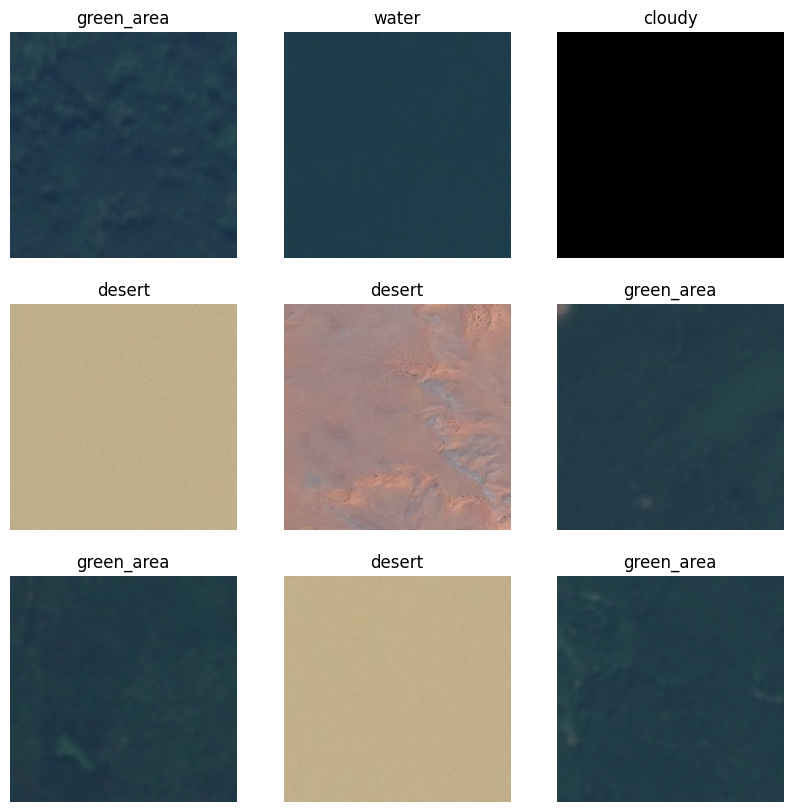

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [24]:
num_classes = 4

def create_cnn_model(input_shape=(256, 256, 3), learning_rate=0.01, momentum=0.9):
    # Build the model
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=input_shape))
    # Convolutional layers
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    # optimizer='adam'
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model(learning_rate=0.002, momentum=0.8)
cnn_model.summary()

/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,348 (12.62 MB)

 Trainable params: 3,309,348 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5179 - loss: 1.1857 - val_accuracy: 0.7549 - val_loss: 0.4145
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8064 - loss: 0.3532 - val_accuracy: 0.7487 - val_loss: 0.4637
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8410 - loss: 0.3061 - val_accuracy: 0.8641 - val_loss: 0.3489
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8775 - loss: 0.2735 - val_accuracy: 0.8668 - val_loss: 0.2523
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8807 - loss: 0.2462 - val_accuracy: 0.8970 - val_loss: 0.2217
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8768 - loss: 0.2669 - val_accuracy: 0.9059 - val_loss: 0.2030
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9202 - loss: 0.1785 - val_accuracy: 0.9254 - val_loss: 0.1848
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8929 - loss: 0.2366 - val_acc

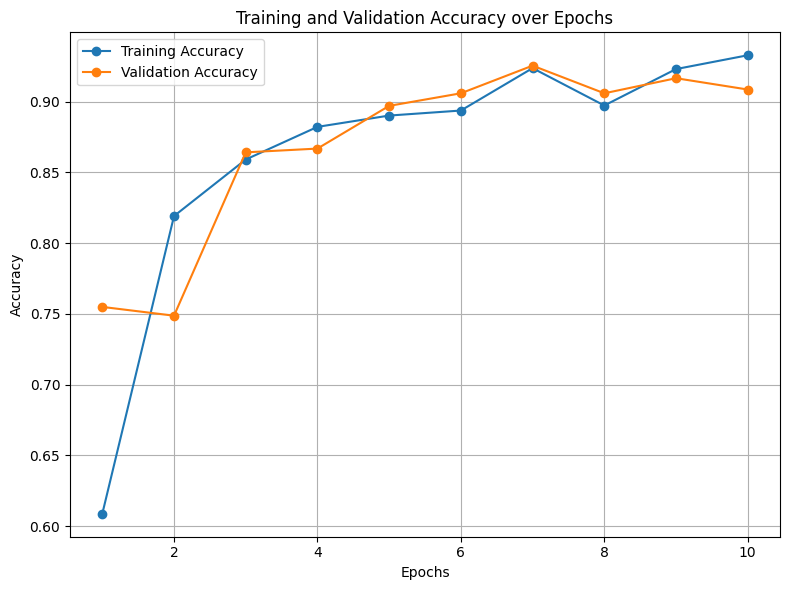

In [26]:
# Extract accuracy and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Extract epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Exploring the best parameters for the SGD algorithm

# Define the parameter grid
learning_rates = [0.001, 0.002, 0.01, 0.1]
momentum_values = [0.8, 0.9, 0.95, 0.99]

# Prepare results storage
results = []

# Iterate over all combinations of learning rates and momentum
for lr in learning_rates:
    for momentum in momentum_values:
        print(f"Training with learning_rate={lr} and momentum={momentum}")
        
        # Define the model (simple example)
        model = create_cnn_model(learning_rate=lr, momentum=momentum)
        
        # Train the model
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=5,  # Use fewer epochs for quick experimentation
            verbose=0  # Set to 1 if you want to see training output
        )
        
        # Record the final validation accuracy
        final_val_acc = history.history['val_accuracy'][-1]
        results.append({'learning_rate': lr, 'momentum': momentum, 'val_accuracy': final_val_acc})

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print(results_df)

# Sort and display the top configurations
top_results = results_df.sort_values(by='val_accuracy', ascending=False).head(5)
print("Top configurations:")
print(top_results)

Training with learning_rate=0.001 and momentum=0.8


/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with learning_rate=0.001 and momentum=0.9
Training with learning_rate=0.001 and momentum=0.95
Training with learning_rate=0.001 and momentum=0.99
Training with learning_rate=0.002 and momentum=0.8
Training with learning_rate=0.002 and momentum=0.9
Training with learning_rate=0.002 and momentum=0.95
Training with learning_rate=0.002 and momentum=0.99
Training with learning_rate=0.01 and momentum=0.8
Training with learning_rate=0.01 and momentum=0.9
Training with learning_rate=0.01 and momentum=0.95
Training with learning_rate=0.01 and momentum=0.99
Training with learning_rate=0.1 and momentum=0.8
Training with learning_rate=0.1 and momentum=0.9
Training with learning_rate=0.1 and momentum=0.95
Training with learning_rate=0.1 and momentum=0.99
    learning_rate  momentum  val_accuracy
0           0.001      0.80      0.883659
1           0.001      0.90      0.875666
2           0.001      0.95      0.916519
3           0.001      0.99      0.718472
4           0.002      0.80  

In [28]:
# Exploring the best parameters for the SGD algorithm - using more epochs but less paramter values

# Define the parameter grid
learning_rates = [0.001, 0.002]
momentum_values = [0.8, 0.9, 0.95]

# Prepare results storage
results = []

# Iterate over all combinations of learning rates and momentum
for lr in learning_rates:
    for momentum in momentum_values:
        print(f"Training with learning_rate={lr} and momentum={momentum}")
        
        # Define the model (simple example)
        model = create_cnn_model(learning_rate=lr, momentum=momentum)
        
        # Train the model
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=10,  # Use fewer epochs for quick experimentation
            verbose=0  # Set to 1 if you want to see training output
        )
        
        # Record the final validation accuracy
        final_val_acc = history.history['val_accuracy'][-1]
        results.append({'learning_rate': lr, 'momentum': momentum, 'val_accuracy': final_val_acc})

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print(results_df)

# Sort and display the top configurations
top_results = results_df.sort_values(by='val_accuracy', ascending=False).head(5)
print("Top configurations:")
print(top_results)

Training with learning_rate=0.001 and momentum=0.8


/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with learning_rate=0.001 and momentum=0.9
Training with learning_rate=0.001 and momentum=0.95
Training with learning_rate=0.002 and momentum=0.8
Training with learning_rate=0.002 and momentum=0.9
Training with learning_rate=0.002 and momentum=0.95
   learning_rate  momentum  val_accuracy
0          0.001      0.80      0.885435
1          0.001      0.90      0.891652
2          0.001      0.95      0.919183
3          0.002      0.80      0.920959
4          0.002      0.90      0.917407
5          0.002      0.95      0.920959
Top configurations:
   learning_rate  momentum  val_accuracy
5          0.002      0.95      0.920959
3          0.002      0.80      0.920959
2          0.001      0.95      0.919183
4          0.002      0.90      0.917407
1          0.001      0.90      0.891652


In [29]:
cnn_model = create_cnn_model(learning_rate=0.002, momentum=0.95)

/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5804 - loss: 0.9758 - val_accuracy: 0.7913 - val_loss: 0.3613
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7886 - loss: 0.3325 - val_accuracy: 0.8908 - val_loss: 0.2905
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8740 - loss: 0.2767 - val_accuracy: 0.8490 - val_loss: 0.3089
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8619 - loss: 0.2643 - val_accuracy: 0.9059 - val_loss: 0.2347
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8614 - loss: 0.2902 - val_accuracy: 0.8162 - val_loss: 0.3226
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.8722 - loss: 0.2695 - val_accuracy: 0.9263 - val_loss: 0.1917
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9132 - loss: 0.2012 - val_accuracy: 0.9218 - val_loss: 0.1831
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8953 - loss: 0.2269 - val_ac

In [31]:
def create_cnn_adam_model(input_shape=(256, 256, 3)):
    # Build the model
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=input_shape))
    # Convolutional layers
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer='adam'
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_adam_model = create_cnn_adam_model()


In [32]:
history = cnn_adam_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7233 - loss: 0.5590 - val_accuracy: 0.7593 - val_loss: 0.3806
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8454 - loss: 0.2892 - val_accuracy: 0.9147 - val_loss: 0.1818
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8959 - loss: 0.2044 - val_accuracy: 0.9076 - val_loss: 0.2030
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9194 - loss: 0.1917 - val_accuracy: 0.9130 - val_loss: 0.1785
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9162 - loss: 0.1883 - val_accuracy: 0.8917 - val_loss: 0.2559
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9224 - loss: 0.1867 - val_accuracy: 0.9298 - val_loss: 0.1450
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9318 - loss: 0.1517 - val_accuracy: 0.9227 - val_loss: 0.1527
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9199 - loss: 0.1745 - val_acc

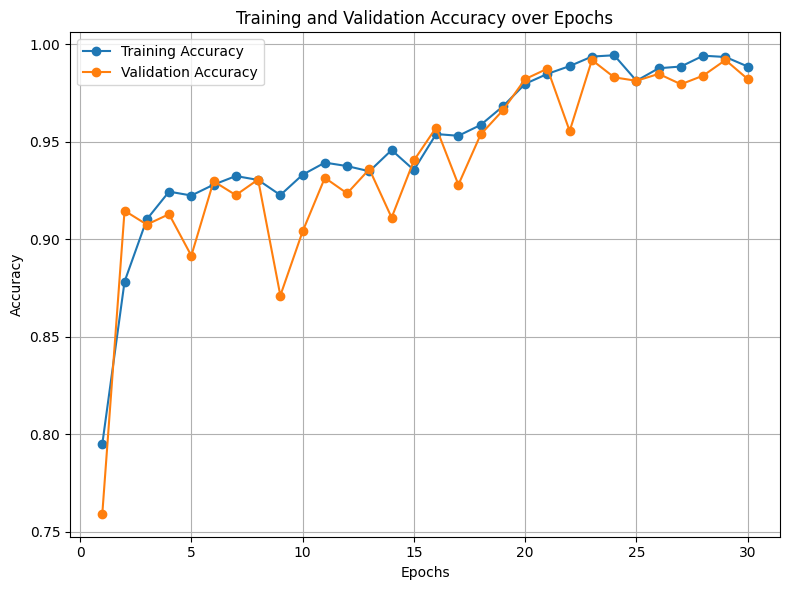

In [33]:
# Extract accuracy and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Extract epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using the adam optimizer leads to the best results, even better than the fine-tuned sgd so we will use this for implementation.